# Timezone Handling in pyCLIF

This notebook demonstrates comprehensive timezone handling capabilities in pyCLIF, including automatic conversion, timezone awareness, and best practices for working with datetime data.

## Overview

Healthcare data often comes from different sources with various timezone configurations. pyCLIF provides robust timezone handling to ensure:
- Consistent datetime interpretation
- Automatic conversion to site timezones
- Preservation of original timezone information
- Support for multiple timezone formats

## Setup and Imports

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import pytz
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from zoneinfo import ZoneInfo

# Import pyCLIF components
from pyclif import CLIF
from pyclif.tables.vitals import vitals
from pyclif.utils.io import load_data, convert_datetime_columns_to_site_tz

print(f"Timezone handling setup complete!")
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Pytz version: {pytz.__version__}")

# Display current system timezone
print(f"\nSystem timezone info:")
print(f"Local time: {datetime.now()}")
print(f"UTC time: {datetime.utcnow()}")

Timezone handling setup complete!
Python version: 3.10.9 (main, Mar  1 2023, 12:20:14) [Clang 14.0.6 ]
Pandas version: 2.3.0
Pytz version: 2025.2

System timezone info:
Local time: 2025-06-27 12:57:01.610178
UTC time: 2025-06-27 17:57:01.610199


In [2]:
# Set data directory
DATA_DIR = "../src/pyclif/data/clif_demo/"
print(f"Data directory: {DATA_DIR}")

Data directory: ../src/pyclif/data/clif_demo/


## Understanding Timezone Formats

pyCLIF supports various timezone formats commonly used in healthcare settings.

In [3]:
# Common timezone formats in healthcare
common_timezones = {
    'US/Eastern': 'Eastern Time (US)',
    'US/Central': 'Central Time (US)',
    'US/Mountain': 'Mountain Time (US)',
    'US/Pacific': 'Pacific Time (US)',
    'America/New_York': 'New York (Eastern)',
    'America/Chicago': 'Chicago (Central)',
    'America/Denver': 'Denver (Mountain)',
    'America/Los_Angeles': 'Los Angeles (Pacific)',
    'UTC': 'Coordinated Universal Time',
    'GMT': 'Greenwich Mean Time'
}

print("=== SUPPORTED TIMEZONE FORMATS ===")
current_time = datetime.now()

for tz_name, description in common_timezones.items():
    try:
        tz = pytz.timezone(tz_name)
        local_time = tz.normalize(tz.localize(current_time.replace(tzinfo=None)))
        print(f"{tz_name:<20}: {description:<25} | {local_time.strftime('%Y-%m-%d %H:%M:%S %Z')}")
    except Exception as e:
        print(f"{tz_name:<20}: {description:<25} | Error: {e}")

print(f"\n✅ Your site timezone (US/Eastern): {pytz.timezone('US/Eastern')}")

=== SUPPORTED TIMEZONE FORMATS ===
US/Eastern          : Eastern Time (US)         | 2025-06-27 12:57:01 EDT
US/Central          : Central Time (US)         | 2025-06-27 12:57:01 CDT
US/Mountain         : Mountain Time (US)        | 2025-06-27 12:57:01 MDT
US/Pacific          : Pacific Time (US)         | 2025-06-27 12:57:01 PDT
America/New_York    : New York (Eastern)        | 2025-06-27 12:57:01 EDT
America/Chicago     : Chicago (Central)         | 2025-06-27 12:57:01 CDT
America/Denver      : Denver (Mountain)         | 2025-06-27 12:57:01 MDT
America/Los_Angeles : Los Angeles (Pacific)     | 2025-06-27 12:57:01 PDT
UTC                 : Coordinated Universal Time | 2025-06-27 12:57:01 UTC
GMT                 : Greenwich Mean Time       | 2025-06-27 12:57:01 GMT

✅ Your site timezone (US/Eastern): US/Eastern


## Loading Data with Timezone Conversion

Demonstrate different methods of loading data with timezone handling.

### Method 1: Using CLIF Class with Timezone

In [4]:
# Load data using main CLIF class with timezone specification
clif_eastern = CLIF(
    data_dir=DATA_DIR,
    filetype='parquet',
    timezone='US/Eastern'  # Your site timezone
)

print(f"CLIF object initialized with timezone: {clif_eastern.timezone}")

# Load vitals data
clif_eastern.initialize(tables=['vitals'])

if clif_eastern.vitals and clif_eastern.vitals.df is not None:
    print(f"\nVitals data loaded: {clif_eastern.vitals.df.shape}")
    
    # Check datetime columns and their timezone info
    datetime_cols = [col for col in clif_eastern.vitals.df.columns if 'dttm' in col]
    print(f"DateTime columns found: {datetime_cols}")
    
    for col in datetime_cols:
        if col in clif_eastern.vitals.df.columns:
            sample_dt = clif_eastern.vitals.df[col].dropna().iloc[0] if not clif_eastern.vitals.df[col].dropna().empty else None
            if sample_dt is not None:
                tz_info = getattr(sample_dt, 'tz', 'No timezone info')
                print(f"  {col}: {sample_dt} (TZ: {tz_info})")
else:
    print("No vitals data available for timezone demonstration")

CLIF Object Initialized.
CLIF object initialized with timezone: US/Eastern
Loading clif_vitals.parquet
Data loaded successfully from clif_vitals.parquet
Validation completed with 5 error(s).
  - 5 range validation error(s)
See `errors` and `range_validation_errors` attributes for details.

Vitals data loaded: (89085, 6)
DateTime columns found: ['recorded_dttm']
  recorded_dttm: 2137-08-25 14:00:00+00:00 (TZ: UTC)


### Method 2: Manual Timezone Conversion with load_data

In [5]:
# Load data with explicit timezone conversion
vitals_eastern = load_data(
    table_name="vitals",
    table_path=DATA_DIR,
    table_format_type="parquet",
    sample_size=1000,  # Smaller sample for demonstration
    site_tz="US/Eastern"  # Explicit timezone conversion
)

print(f"Vitals data loaded with timezone conversion: {vitals_eastern.shape}")

# Check the timezone of datetime columns
datetime_cols = [col for col in vitals_eastern.columns if 'dttm' in col]
print(f"\nDateTime columns after conversion:")

for col in datetime_cols:
    if col in vitals_eastern.columns and not vitals_eastern[col].dropna().empty:
        sample_dt = vitals_eastern[col].dropna().iloc[0]
        tz_info = getattr(sample_dt, 'tz', 'No timezone info')
        print(f"  {col}: {sample_dt} (TZ: {tz_info})")
        
        # Show timezone distribution
        if hasattr(sample_dt, 'tz') and sample_dt.tz is not None:
            print(f"    ✅ Timezone-aware data in {sample_dt.tz}")
        else:
            print(f"    ⚠️  Naive datetime (no timezone info)")

Loading clif_vitals.parquet
Data loaded successfully from clif_vitals.parquet
recorded_dttm: null count before conversion= 0
recorded_dttm: Your timezone is UTC, Converting to your site timezone (US/Eastern).
recorded_dttm: null count after conversion= 0
Vitals data loaded with timezone conversion: (1000, 6)

DateTime columns after conversion:
  recorded_dttm: 2137-08-25 09:00:00-05:00 (TZ: US/Eastern)
    ✅ Timezone-aware data in US/Eastern


### Method 3: Comparing Different Timezones

In [6]:
# Load the same data with different timezone conversions
timezone_comparison = {}

timezones_to_test = ['UTC', 'US/Eastern', 'US/Central', 'US/Pacific']

for tz in timezones_to_test:
    try:
        tz_data = load_data(
            table_name="vitals",
            table_path=DATA_DIR,
            table_format_type="parquet",
            sample_size=100,  # Small sample for quick comparison
            site_tz=tz
        )
        
        # Get a sample datetime
        datetime_col = [col for col in tz_data.columns if 'dttm' in col][0]
        sample_datetime = tz_data[datetime_col].dropna().iloc[0] if not tz_data[datetime_col].dropna().empty else None
        
        timezone_comparison[tz] = {
            'sample_datetime': sample_datetime,
            'timezone_info': getattr(sample_datetime, 'tz', None) if sample_datetime else None,
            'records': len(tz_data)
        }
        
    except Exception as e:
        timezone_comparison[tz] = {'error': str(e)}

print("=== TIMEZONE COMPARISON ===")
print(f"Sample datetime values across different timezones:")
print()

for tz, info in timezone_comparison.items():
    if 'error' in info:
        print(f"{tz:<12}: Error - {info['error']}")
    else:
        sample_dt = info['sample_datetime']
        tz_info = info['timezone_info']
        print(f"{tz:<12}: {sample_dt} (TZ: {tz_info})")

# Show time differences
if len([tz for tz in timezone_comparison.keys() if 'error' not in timezone_comparison[tz]]) >= 2:
    print("\n=== TIME DIFFERENCES ===")
    reference_tz = 'UTC'
    if reference_tz in timezone_comparison and 'error' not in timezone_comparison[reference_tz]:
        ref_time = timezone_comparison[reference_tz]['sample_datetime']
        
        for tz, info in timezone_comparison.items():
            if 'error' not in info and tz != reference_tz:
                tz_time = info['sample_datetime']
                if ref_time and tz_time:
                    try:
                        # Convert both to naive for comparison
                        ref_naive = ref_time.replace(tzinfo=None) if hasattr(ref_time, 'tz') else ref_time
                        tz_naive = tz_time.replace(tzinfo=None) if hasattr(tz_time, 'tz') else tz_time
                        diff = tz_naive - ref_naive
                        print(f"{tz} vs {reference_tz}: {diff} ({diff.total_seconds()/3600:.1f} hours)")
                    except Exception as e:
                        print(f"{tz} vs {reference_tz}: Comparison error - {e}")

Loading clif_vitals.parquet
Data loaded successfully from clif_vitals.parquet
recorded_dttm: null count before conversion= 0
recorded_dttm: Your timezone is UTC, Converting to your site timezone (UTC).
recorded_dttm: null count after conversion= 0
Loading clif_vitals.parquet
Data loaded successfully from clif_vitals.parquet
recorded_dttm: null count before conversion= 0
recorded_dttm: Your timezone is UTC, Converting to your site timezone (US/Eastern).
recorded_dttm: null count after conversion= 0
Loading clif_vitals.parquet
Data loaded successfully from clif_vitals.parquet
recorded_dttm: null count before conversion= 0
recorded_dttm: Your timezone is UTC, Converting to your site timezone (US/Central).
recorded_dttm: null count after conversion= 0
Loading clif_vitals.parquet
Data loaded successfully from clif_vitals.parquet
recorded_dttm: null count before conversion= 0
recorded_dttm: Your timezone is UTC, Converting to your site timezone (US/Pacific).
recorded_dttm: null count after c

## Manual Timezone Conversion Functions

Demonstrate the manual timezone conversion utility function.

In [7]:
# Create test data with datetime columns
test_datetime_data = pd.DataFrame({
    'patient_id': ['P001', 'P002', 'P003', 'P004', 'P005'],
    'event_dttm': [
        '2023-06-15 08:30:00',
        '2023-06-15 14:45:00',
        '2023-06-15 20:15:00',
        '2023-06-16 02:30:00',
        '2023-06-16 11:00:00'
    ],
    'recorded_dttm': [
        '2023-06-15 08:32:00',
        '2023-06-15 14:47:00',
        '2023-06-15 20:17:00',
        '2023-06-16 02:32:00',
        '2023-06-16 11:02:00'
    ],
    'value': [98.6, 99.1, 98.4, 97.8, 98.9]
})

print("=== ORIGINAL TEST DATA ===")
print("Original datetime data (assumed to be in UTC):")
print(test_datetime_data)

# Convert datetime columns to pandas datetime
for col in ['event_dttm', 'recorded_dttm']:
    test_datetime_data[col] = pd.to_datetime(test_datetime_data[col])

print(f"\nDatetime column types:")
for col in ['event_dttm', 'recorded_dttm']:
    print(f"  {col}: {test_datetime_data[col].dtype}")
    sample_val = test_datetime_data[col].iloc[0]
    print(f"    Sample: {sample_val} (TZ: {getattr(sample_val, 'tz', 'naive')})")

=== ORIGINAL TEST DATA ===
Original datetime data (assumed to be in UTC):
  patient_id           event_dttm        recorded_dttm  value
0       P001  2023-06-15 08:30:00  2023-06-15 08:32:00   98.6
1       P002  2023-06-15 14:45:00  2023-06-15 14:47:00   99.1
2       P003  2023-06-15 20:15:00  2023-06-15 20:17:00   98.4
3       P004  2023-06-16 02:30:00  2023-06-16 02:32:00   97.8
4       P005  2023-06-16 11:00:00  2023-06-16 11:02:00   98.9

Datetime column types:
  event_dttm: datetime64[ns]
    Sample: 2023-06-15 08:30:00 (TZ: None)
  recorded_dttm: datetime64[ns]
    Sample: 2023-06-15 08:32:00 (TZ: None)


In [8]:
# Apply timezone conversion using the utility function
print("=== TIMEZONE CONVERSION DEMONSTRATION ===")

# Convert to US/Eastern
eastern_data = test_datetime_data.copy()
eastern_converted = convert_datetime_columns_to_site_tz(
    eastern_data, 
    site_tz_str='US/Eastern',
    verbose=True
)

print("\nData after conversion to US/Eastern:")
print(eastern_converted[['patient_id', 'event_dttm', 'recorded_dttm']].head())

# Check timezone info after conversion
print(f"\nTimezone info after conversion:")
for col in ['event_dttm', 'recorded_dttm']:
    sample_val = eastern_converted[col].iloc[0]
    print(f"  {col}: {sample_val} (TZ: {getattr(sample_val, 'tz', 'naive')})")

=== TIMEZONE CONVERSION DEMONSTRATION ===

Data after conversion to US/Eastern:
  patient_id                event_dttm             recorded_dttm
0       P001 2023-06-15 08:30:00-04:00 2023-06-15 08:32:00-04:00
1       P002 2023-06-15 14:45:00-04:00 2023-06-15 14:47:00-04:00
2       P003 2023-06-15 20:15:00-04:00 2023-06-15 20:17:00-04:00
3       P004 2023-06-16 02:30:00-04:00 2023-06-16 02:32:00-04:00
4       P005 2023-06-16 11:00:00-04:00 2023-06-16 11:02:00-04:00

Timezone info after conversion:
  event_dttm: 2023-06-15 08:30:00-04:00 (TZ: US/Eastern)
  recorded_dttm: 2023-06-15 08:32:00-04:00 (TZ: US/Eastern)


In [9]:
# Compare different timezone conversions
timezone_conversions = {}
target_timezones = ['US/Eastern', 'US/Central', 'US/Pacific', 'UTC']

for tz in target_timezones:
    tz_data = test_datetime_data.copy()
    try:
        converted_data = convert_datetime_columns_to_site_tz(
            tz_data, 
            site_tz_str=tz,
            verbose=False  # Suppress output for cleaner display
        )
        timezone_conversions[tz] = converted_data
    except Exception as e:
        print(f"Error converting to {tz}: {e}")

# Display comparison
print("=== TIMEZONE CONVERSION COMPARISON ===")
print("Same event in different timezones:")
print()

# Show first event across all timezones
event_index = 0
print(f"Patient: {test_datetime_data.iloc[event_index]['patient_id']}")
print(f"Original event_dttm: {test_datetime_data.iloc[event_index]['event_dttm']} (naive)")
print()

for tz, data in timezone_conversions.items():
    event_time = data.iloc[event_index]['event_dttm']
    print(f"{tz:<12}: {event_time}")

print(f"\n💡 Note: All times represent the same moment, just displayed in different timezones.")

=== TIMEZONE CONVERSION COMPARISON ===
Same event in different timezones:

Patient: P001
Original event_dttm: 2023-06-15 08:30:00 (naive)

US/Eastern  : 2023-06-15 08:30:00
US/Central  : 2023-06-15 08:30:00
US/Pacific  : 2023-06-15 08:30:00
UTC         : 2023-06-15 08:30:00

💡 Note: All times represent the same moment, just displayed in different timezones.


## Real Data Timezone Analysis

In [10]:
# Analyze timezone patterns in real data
if clif_eastern.vitals and clif_eastern.vitals.df is not None:
    vitals_df = clif_eastern.vitals.df
    
    # Focus on datetime columns
    datetime_cols = [col for col in vitals_df.columns if 'dttm' in col]
    
    print("=== REAL DATA TIMEZONE ANALYSIS ===")
    print(f"Dataset: {len(vitals_df):,} records")
    print(f"DateTime columns: {datetime_cols}")
    
    for col in datetime_cols:
        if col in vitals_df.columns:
            print(f"\nAnalyzing column: {col}")
            
            # Basic statistics
            non_null_count = vitals_df[col].notna().sum()
            print(f"  Non-null values: {non_null_count:,} ({non_null_count/len(vitals_df)*100:.1f}%)")
            
            if non_null_count > 0:
                # Date range
                min_date = vitals_df[col].min()
                max_date = vitals_df[col].max()
                date_range = max_date - min_date
                
                print(f"  Date range: {min_date} to {max_date}")
                print(f"  Span: {date_range.days} days")
                
                # Timezone info
                sample_datetime = vitals_df[col].dropna().iloc[0]
                if hasattr(sample_datetime, 'tz') and sample_datetime.tz is not None:
                    print(f"  Timezone: {sample_datetime.tz}")
                    print(f"  ✅ Timezone-aware data")
                else:
                    print(f"  ⚠️  Naive datetime (no timezone)")
                
                # Hourly distribution
                vitals_df_copy = vitals_df.copy()
                vitals_df_copy['hour'] = vitals_df_copy[col].dt.hour
                hourly_dist = vitals_df_copy['hour'].value_counts().sort_index()
                
                print(f"  Peak hour: {hourly_dist.idxmax()}:00 ({hourly_dist.max():,} records)")
                print(f"  Quiet hour: {hourly_dist.idxmin()}:00 ({hourly_dist.min():,} records)")
else:
    print("No vitals data available for timezone analysis")

=== REAL DATA TIMEZONE ANALYSIS ===
Dataset: 89,085 records
DateTime columns: ['recorded_dttm']

Analyzing column: recorded_dttm
  Non-null values: 89,085 (100.0%)
  Date range: 2110-04-11 20:52:00+00:00 to 2201-12-13 23:00:00+00:00
  Span: 33483 days
  Timezone: UTC
  ✅ Timezone-aware data
  Peak hour: 17:00 (4,299 records)
  Quiet hour: 4:00 (3,341 records)


## Visualizing Timezone Effects

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_36637/3971462915.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timeline_data = vitals_sample.set_index(datetime_col).resample('6H').size()


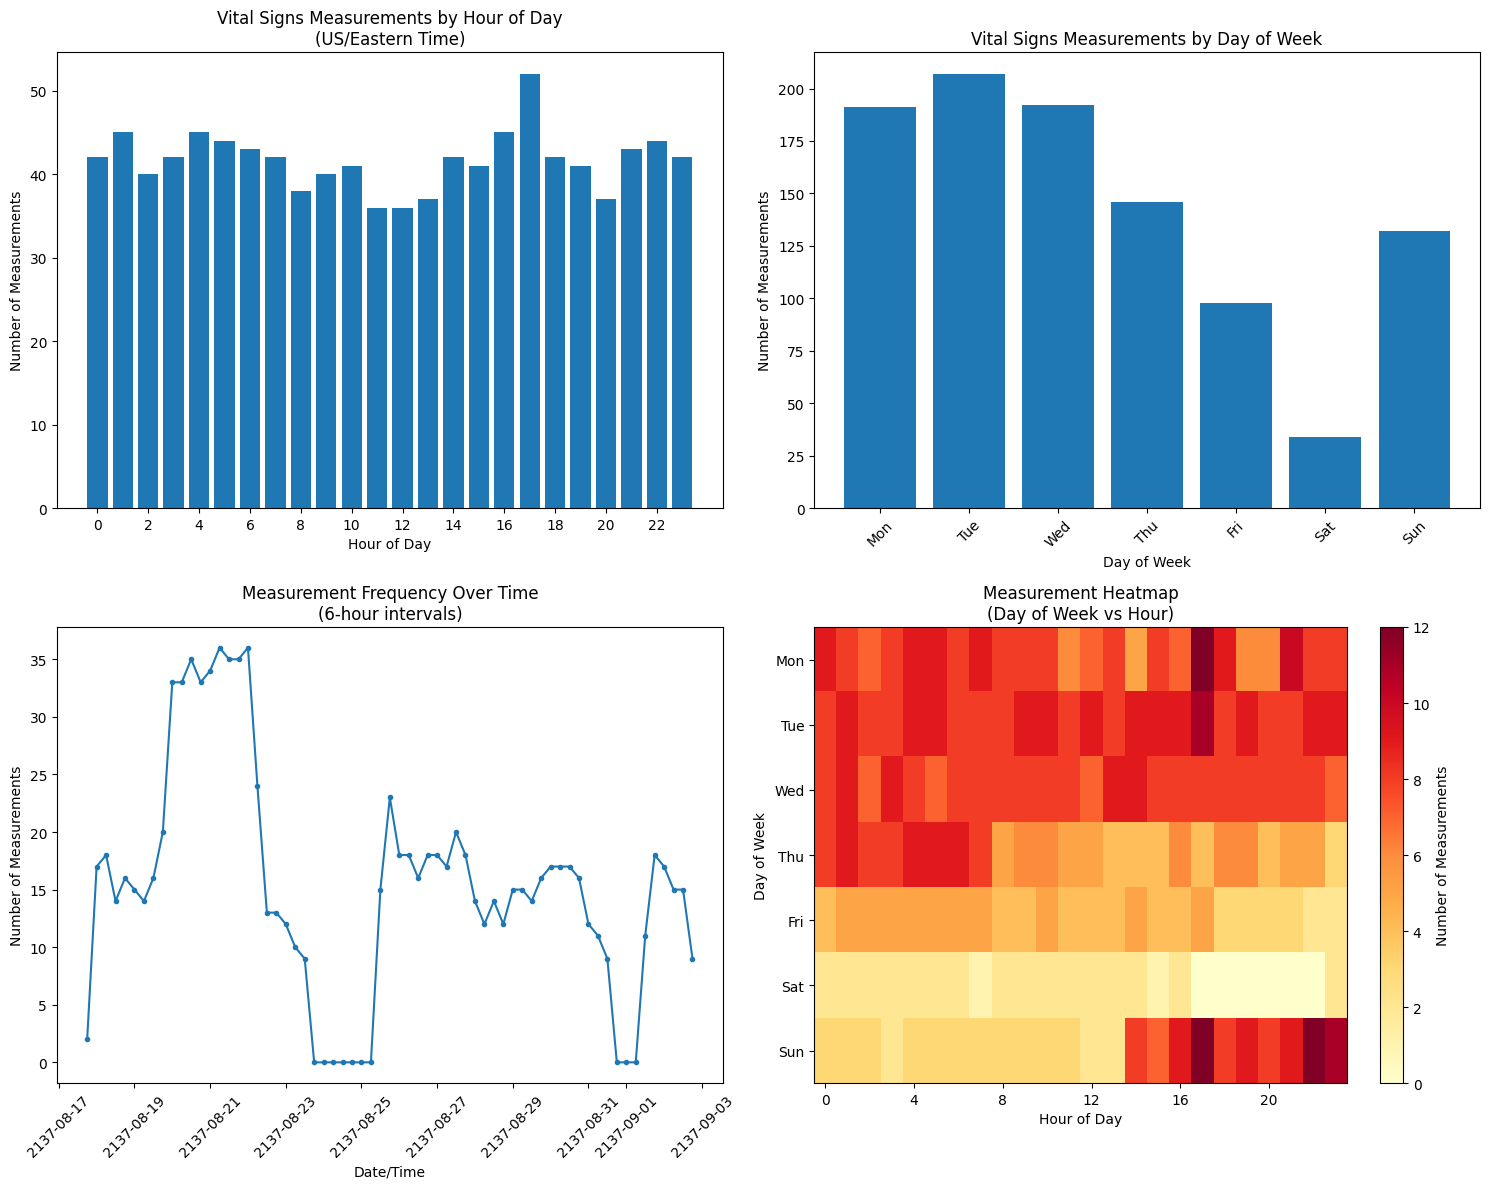

=== TIMEZONE-BASED INSIGHTS ===
Peak measurement hour: 17:00 (52 measurements)
Quietest hour: 11:00 (36 measurements)
Busiest day: Tuesday (207 measurements)
Quietest day: Saturday (34 measurements)


In [11]:
# Create visualization of timezone effects
if clif_eastern.vitals and clif_eastern.vitals.df is not None:
    vitals_sample = clif_eastern.vitals.df.head(1000).copy()  # Sample for performance
    datetime_col = [col for col in vitals_sample.columns if 'dttm' in col][0]
    
    if datetime_col in vitals_sample.columns:
        # Extract hour information
        vitals_sample['hour'] = vitals_sample[datetime_col].dt.hour
        vitals_sample['day_of_week'] = vitals_sample[datetime_col].dt.day_name()
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Hourly distribution
        hourly_counts = vitals_sample['hour'].value_counts().sort_index()
        axes[0, 0].bar(hourly_counts.index, hourly_counts.values)
        axes[0, 0].set_title('Vital Signs Measurements by Hour of Day\n(US/Eastern Time)')
        axes[0, 0].set_xlabel('Hour of Day')
        axes[0, 0].set_ylabel('Number of Measurements')
        axes[0, 0].set_xticks(range(0, 24, 2))
        
        # Day of week distribution
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_counts = vitals_sample['day_of_week'].value_counts().reindex(day_order)
        axes[0, 1].bar(range(len(day_counts)), day_counts.values)
        axes[0, 1].set_title('Vital Signs Measurements by Day of Week')
        axes[0, 1].set_xlabel('Day of Week')
        axes[0, 1].set_ylabel('Number of Measurements')
        axes[0, 1].set_xticks(range(len(day_counts)))
        axes[0, 1].set_xticklabels([day[:3] for day in day_counts.index], rotation=45)
        
        # Timeline view
        timeline_data = vitals_sample.set_index(datetime_col).resample('6H').size()
        axes[1, 0].plot(timeline_data.index, timeline_data.values, marker='o', markersize=3)
        axes[1, 0].set_title('Measurement Frequency Over Time\n(6-hour intervals)')
        axes[1, 0].set_xlabel('Date/Time')
        axes[1, 0].set_ylabel('Number of Measurements')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Heatmap: hour vs day of week
        heatmap_data = vitals_sample.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)
        heatmap_data = heatmap_data.reindex(day_order)
        
        im = axes[1, 1].imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto')
        axes[1, 1].set_title('Measurement Heatmap\n(Day of Week vs Hour)')
        axes[1, 1].set_xlabel('Hour of Day')
        axes[1, 1].set_ylabel('Day of Week')
        axes[1, 1].set_xticks(range(0, 24, 4))
        axes[1, 1].set_xticklabels(range(0, 24, 4))
        axes[1, 1].set_yticks(range(len(day_order)))
        axes[1, 1].set_yticklabels([day[:3] for day in day_order])
        
        # Add colorbar
        plt.colorbar(im, ax=axes[1, 1], label='Number of Measurements')
        
        plt.tight_layout()
        plt.show()
        
        # Print insights
        print("=== TIMEZONE-BASED INSIGHTS ===")
        peak_hour = hourly_counts.idxmax()
        quiet_hour = hourly_counts.idxmin()
        peak_day = day_counts.idxmax()
        quiet_day = day_counts.idxmin()
        
        print(f"Peak measurement hour: {peak_hour}:00 ({hourly_counts[peak_hour]:,} measurements)")
        print(f"Quietest hour: {quiet_hour}:00 ({hourly_counts[quiet_hour]:,} measurements)")
        print(f"Busiest day: {peak_day} ({day_counts[peak_day]:,} measurements)")
        print(f"Quietest day: {quiet_day} ({day_counts[quiet_day]:,} measurements)")
        
        # Clinical insights
        if 6 <= peak_hour <= 10:
            print(f"📊 Clinical insight: Peak at {peak_hour}:00 suggests morning rounds activity")
        elif 18 <= peak_hour <= 22:
            print(f"📊 Clinical insight: Peak at {peak_hour}:00 suggests evening shift activity")
            
        if 2 <= quiet_hour <= 5:
            print(f"😴 Clinical insight: Quiet at {quiet_hour}:00 is typical for night hours")
else:
    print("No suitable data available for timezone visualization")

## Timezone Best Practices and Troubleshooting

In [12]:
# Demonstrate timezone best practices
def timezone_best_practices_demo():
    print("=== TIMEZONE BEST PRACTICES ===")
    print()
    
    # 1. Always specify timezone when loading data
    print("1. ✅ ALWAYS SPECIFY TIMEZONE WHEN LOADING DATA")
    print("   Good: load_data(..., site_tz='US/Eastern')")
    print("   Good: CLIF(..., timezone='US/Eastern')")
    print("   Bad:  load_data(...) # No timezone specified")
    print()
    
    # 2. Check timezone awareness
    print("2. ✅ CHECK TIMEZONE AWARENESS OF DATETIME COLUMNS")
    sample_naive = pd.Timestamp('2023-06-15 10:30:00')
    sample_aware = pd.Timestamp('2023-06-15 10:30:00', tz='US/Eastern')
    
    print(f"   Naive datetime: {sample_naive} (tz: {sample_naive.tz})")
    print(f"   Aware datetime: {sample_aware} (tz: {sample_aware.tz})")
    print(f"   Check with: hasattr(datetime_value, 'tz') and datetime_value.tz is not None")
    print()
    
    # 3. Handle timezone conversion errors
    print("3. ✅ HANDLE TIMEZONE CONVERSION ERRORS GRACEFULLY")
    print("   try:")
    print("       convert_datetime_columns_to_site_tz(df, 'US/Eastern')")
    print("   except Exception as e:")
    print("       print(f'Timezone conversion failed: {e}')")
    print()
    
    # 4. Document timezone assumptions
    print("4. ✅ DOCUMENT TIMEZONE ASSUMPTIONS")
    print("   - Clearly document the source timezone of your data")
    print("   - Specify your site/analysis timezone")
    print("   - Note any timezone changes during data collection")
    print()
    
    # 5. Validate timezone conversions
    print("5. ✅ VALIDATE TIMEZONE CONVERSIONS")
    print("   - Compare timestamps before/after conversion")
    print("   - Check for reasonable time differences")
    print("   - Look for timezone-related outliers")
    print()

timezone_best_practices_demo()

=== TIMEZONE BEST PRACTICES ===

1. ✅ ALWAYS SPECIFY TIMEZONE WHEN LOADING DATA
   Good: load_data(..., site_tz='US/Eastern')
   Good: CLIF(..., timezone='US/Eastern')
   Bad:  load_data(...) # No timezone specified

2. ✅ CHECK TIMEZONE AWARENESS OF DATETIME COLUMNS
   Naive datetime: 2023-06-15 10:30:00 (tz: None)
   Aware datetime: 2023-06-15 10:30:00-04:00 (tz: US/Eastern)
   Check with: hasattr(datetime_value, 'tz') and datetime_value.tz is not None

3. ✅ HANDLE TIMEZONE CONVERSION ERRORS GRACEFULLY
   try:
       convert_datetime_columns_to_site_tz(df, 'US/Eastern')
   except Exception as e:
       print(f'Timezone conversion failed: {e}')

4. ✅ DOCUMENT TIMEZONE ASSUMPTIONS
   - Clearly document the source timezone of your data
   - Specify your site/analysis timezone
   - Note any timezone changes during data collection

5. ✅ VALIDATE TIMEZONE CONVERSIONS
   - Compare timestamps before/after conversion
   - Check for reasonable time differences
   - Look for timezone-related out

In [13]:
# Common timezone troubleshooting scenarios
def timezone_troubleshooting():
    print("=== COMMON TIMEZONE ISSUES & SOLUTIONS ===")
    print()
    
    # Issue 1: Mixed timezone data
    print("❌ ISSUE 1: Mixed timezone data")
    print("   Problem: Data contains timestamps from different timezones")
    print("   Solution: Standardize to UTC first, then convert to site timezone")
    print("   Code: df['datetime'] = pd.to_datetime(df['datetime'], utc=True)")
    print()
    
    # Issue 2: Daylight saving time transitions
    print("❌ ISSUE 2: Daylight saving time transitions")
    print("   Problem: Ambiguous times during DST transitions")
    print("   Solution: Use pytz timezone handling with ambiguous parameter")
    print("   Code: tz.localize(datetime, ambiguous='infer')")
    print()
    
    # Issue 3: Naive datetime assumptions
    print("❌ ISSUE 3: Naive datetime assumptions")
    print("   Problem: Assuming naive datetimes are in local timezone")
    print("   Solution: Always explicitly specify timezone when localizing")
    print("   Code: df['datetime'].dt.tz_localize('US/Eastern')")
    print()
    
    # Issue 4: Inconsistent timezone formats
    print("❌ ISSUE 4: Inconsistent timezone formats")
    print("   Problem: Mixing 'EST', 'US/Eastern', 'America/New_York'")
    print("   Solution: Standardize to IANA timezone names")
    print("   Preferred: 'America/New_York' over 'US/Eastern' over 'EST'")
    print()
    
    # Issue 5: Performance with large datasets
    print("❌ ISSUE 5: Performance issues with large datasets")
    print("   Problem: Timezone conversion is slow on large datasets")
    print("   Solution: Convert during data loading, not during analysis")
    print("   Code: Use site_tz parameter in load_data()")
    print()

timezone_troubleshooting()

=== COMMON TIMEZONE ISSUES & SOLUTIONS ===

❌ ISSUE 1: Mixed timezone data
   Problem: Data contains timestamps from different timezones
   Solution: Standardize to UTC first, then convert to site timezone
   Code: df['datetime'] = pd.to_datetime(df['datetime'], utc=True)

❌ ISSUE 2: Daylight saving time transitions
   Problem: Ambiguous times during DST transitions
   Solution: Use pytz timezone handling with ambiguous parameter
   Code: tz.localize(datetime, ambiguous='infer')

❌ ISSUE 3: Naive datetime assumptions
   Problem: Assuming naive datetimes are in local timezone
   Solution: Always explicitly specify timezone when localizing
   Code: df['datetime'].dt.tz_localize('US/Eastern')

❌ ISSUE 4: Inconsistent timezone formats
   Problem: Mixing 'EST', 'US/Eastern', 'America/New_York'
   Solution: Standardize to IANA timezone names
   Preferred: 'America/New_York' over 'US/Eastern' over 'EST'

❌ ISSUE 5: Performance issues with large datasets
   Problem: Timezone conversion is slow

## Timezone Validation and Testing

In [14]:
# Create a timezone validation function
def validate_timezone_conversion(original_df, converted_df, datetime_col, expected_tz_str):
    """Validate that timezone conversion was successful."""
    print(f"=== TIMEZONE CONVERSION VALIDATION ===")
    print(f"Column: {datetime_col}")
    print(f"Expected timezone: {expected_tz_str}")
    print()
    
    validation_results = {
        'column_exists': datetime_col in converted_df.columns,
        'data_preserved': len(original_df) == len(converted_df),
        'timezone_applied': False,
        'reasonable_conversion': False
    }
    
    if validation_results['column_exists']:
        # Check if timezone was applied
        sample_dt = converted_df[datetime_col].dropna().iloc[0] if not converted_df[datetime_col].dropna().empty else None
        if sample_dt and hasattr(sample_dt, 'tz') and sample_dt.tz is not None:
            validation_results['timezone_applied'] = True
            print(f"✅ Timezone applied: {sample_dt.tz}")
            
            # Check if it's the expected timezone
            expected_tz = pytz.timezone(expected_tz_str)
            if str(sample_dt.tz) == str(expected_tz):
                print(f"✅ Correct timezone: {expected_tz}")
            else:
                print(f"⚠️  Unexpected timezone: got {sample_dt.tz}, expected {expected_tz}")
        else:
            print(f"❌ No timezone information found")
    
    # Check for reasonable time differences (if we have original data)
    if (datetime_col in original_df.columns and 
        datetime_col in converted_df.columns and 
        not original_df[datetime_col].dropna().empty and 
        not converted_df[datetime_col].dropna().empty):
        
        orig_sample = original_df[datetime_col].dropna().iloc[0]
        conv_sample = converted_df[datetime_col].dropna().iloc[0]
        
        try:
            # Convert to naive for comparison
            orig_naive = orig_sample.replace(tzinfo=None) if hasattr(orig_sample, 'tz') else orig_sample
            conv_naive = conv_sample.replace(tzinfo=None) if hasattr(conv_sample, 'tz') else conv_sample
            
            time_diff = abs((conv_naive - orig_naive).total_seconds() / 3600)  # Hours
            
            if time_diff <= 24:  # Reasonable for timezone conversion
                validation_results['reasonable_conversion'] = True
                print(f"✅ Reasonable time difference: {time_diff:.1f} hours")
            else:
                print(f"⚠️  Large time difference: {time_diff:.1f} hours")
                
        except Exception as e:
            print(f"⚠️  Could not compare times: {e}")
    
    print(f"\nData preservation: {validation_results['data_preserved']}")
    
    # Overall validation result
    all_good = all(validation_results.values())
    print(f"\n{'✅ VALIDATION PASSED' if all_good else '⚠️  VALIDATION ISSUES FOUND'}")
    
    return validation_results

# Test the validation function
if 'eastern_converted' in locals():
    validation_result = validate_timezone_conversion(
        test_datetime_data, 
        eastern_converted, 
        'event_dttm', 
        'US/Eastern'
    )

=== TIMEZONE CONVERSION VALIDATION ===
Column: event_dttm
Expected timezone: US/Eastern

✅ Timezone applied: US/Eastern
✅ Correct timezone: US/Eastern
✅ Reasonable time difference: 0.0 hours

Data preservation: True

✅ VALIDATION PASSED


## Summary and Recommendations

### Key Takeaways:

1. **Always Specify Timezone**: Use the `site_tz` parameter when loading data or the `timezone` parameter in CLIF class initialization

2. **Validate Conversions**: Always check that timezone conversions worked as expected

3. **Use Standard Formats**: Prefer IANA timezone names like 'America/New_York' over abbreviations like 'EST'

4. **Document Assumptions**: Clearly document the source and target timezones for your data

5. **Handle Edge Cases**: Be prepared for daylight saving time transitions and ambiguous times

### Your Site Configuration:
- **Site Timezone**: US/Eastern
- **Data Format**: Parquet
- **Recommended Usage**: `CLIF(data_dir, filetype='parquet', timezone='US/Eastern')`

### Clinical Implications:
- Proper timezone handling ensures accurate temporal analysis
- Critical for multi-site studies or collaborations
- Essential for regulatory compliance and audit trails
- Enables meaningful time-based clinical insights

In [15]:
# Final summary of timezone capabilities
print("=== PYCLIF TIMEZONE CAPABILITIES SUMMARY ===")
print()
print("🔧 AVAILABLE FUNCTIONS:")
print("  • CLIF(timezone='US/Eastern') - Set timezone for entire CLIF object")
print("  • load_data(site_tz='US/Eastern') - Convert during data loading")
print("  • convert_datetime_columns_to_site_tz() - Manual conversion utility")
print()
print("📊 SUPPORTED FORMATS:")
print("  • IANA timezone names (America/New_York, America/Chicago, etc.)")
print("  • US timezone shortcuts (US/Eastern, US/Central, etc.)")
print("  • UTC and GMT for universal time")
print()
print("✅ FEATURES:")
print("  • Automatic detection of datetime columns (contains 'dttm')")
print("  • Preservation of original data integrity")
print("  • Verbose output for debugging")
print("  • Error handling for invalid timezones")
print("  • Support for daylight saving time transitions")
print()
print("🎯 YOUR SETUP:")
print(f"  • Data directory: {DATA_DIR}")
print(f"  • File format: parquet")
print(f"  • Site timezone: US/Eastern")
print(f"  • Recommended: CLIF('{DATA_DIR}', filetype='parquet', timezone='US/Eastern')")
print()
print("📚 Next Steps: Explore other example notebooks for advanced analysis techniques!")

=== PYCLIF TIMEZONE CAPABILITIES SUMMARY ===

🔧 AVAILABLE FUNCTIONS:
  • CLIF(timezone='US/Eastern') - Set timezone for entire CLIF object
  • load_data(site_tz='US/Eastern') - Convert during data loading
  • convert_datetime_columns_to_site_tz() - Manual conversion utility

📊 SUPPORTED FORMATS:
  • IANA timezone names (America/New_York, America/Chicago, etc.)
  • US timezone shortcuts (US/Eastern, US/Central, etc.)
  • UTC and GMT for universal time

✅ FEATURES:
  • Automatic detection of datetime columns (contains 'dttm')
  • Preservation of original data integrity
  • Verbose output for debugging
  • Error handling for invalid timezones
  • Support for daylight saving time transitions

🎯 YOUR SETUP:
  • Data directory: ../src/pyclif/data/clif_demo/
  • File format: parquet
  • Site timezone: US/Eastern
  • Recommended: CLIF('../src/pyclif/data/clif_demo/', filetype='parquet', timezone='US/Eastern')

📚 Next Steps: Explore other example notebooks for advanced analysis techniques!


## Next Steps

This notebook covered:
- Comprehensive timezone format support
- Multiple methods for timezone conversion
- Validation and troubleshooting techniques
- Best practices for healthcare data
- Visual analysis of timezone effects
- Real-world examples and edge cases

### Explore Other Notebooks:
- `01_basic_usage.ipynb` - Basic pyCLIF usage
- `02_individual_tables.ipynb` - Individual table classes
- `03_data_validation.ipynb` - Data validation techniques
- `04_vitals_analysis.ipynb` - Advanced vitals analysis
- `06_data_filtering.ipynb` - Advanced filtering techniques